In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import FinaltimeFreeCost, UnicycleCost
from constraints import UnicycleConstraints
from PTR_tf_free import PTR_tf_free
from PTR_in_MPC import PTR_in_MPC
from Scaling import TrajectoryScaling

from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

(CVXPY) Feb 23 02:27:51 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <C5D99CE8-1937-36B7-A660-713E029B0166> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib

## Nominal trajectory generation

In [4]:
ix = 3
iu = 2
ih = 2
N = 50
tf = 10
delT = tf/N
max_iter = 30

In [5]:
myModel = UnicycleModel.unicycle('Hello',ix,iu,'analytic')
myCost = FinaltimeFreeCost.Finaltime('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu,[],[])

In [6]:
xi = np.zeros(3)
xi[0] = -5.0
xi[1] = -5.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
    
u0 = np.zeros((N+1,iu))
ui = np.array([2,0])
uf = np.array([2,0])
for i in range(N+1) :
    u0[i] = (N-i)/N * ui + i/N * uf
    
x_max = np.array([5,5,np.deg2rad(90)])
x_min = np.zeros(ix)

u_max = np.array([2,np.deg2rad(90)]) 
u_min = np.array([0,0])


myScaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)
Sx,iSx,sx,Su,iSu,su = myScaling.get_scaling()


TrajOpt = PTR_tf_free('unicycle',N,tf,max_iter,myModel,myCost,myConst,myScaling,
          type_discretization="foh",w_tf=1,w_vc=1e3,w_tr=1e-1,tol_vc=1e-6,tol_tr=1e-3)

Is DPP?  True


In [7]:
xfwd,ufwd,xnom,unom,tfnom,total_num_iter,l_all,l_tf,l_vc,l_tr,history_nom  = TrajOpt.run(x0,u0,xi,xf)
print("final time {:}".format(tfnom))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-07
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                          ..:: Aircraft Landing by SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ thrust  │ control   │ reduction  │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │ rate      │ ratio      │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │5.696      │5.000     │0        │0          │0           │1(-14.07)│0(6.958 )│0(0.128 )│
│2     │7.734      │6.976     │0        │0          │0.597       │1(-14.04)│0(7.573 )│0(0.065 )│
│3     │7.324      │7.132     │0        │0          │0.869       │1(-13.98)│0(1.919 )│0(0.015 )│
│4     │7.256      │7.253     

In [8]:
t_nom = np.array([i for i in range(N+1)]) / N * tfnom

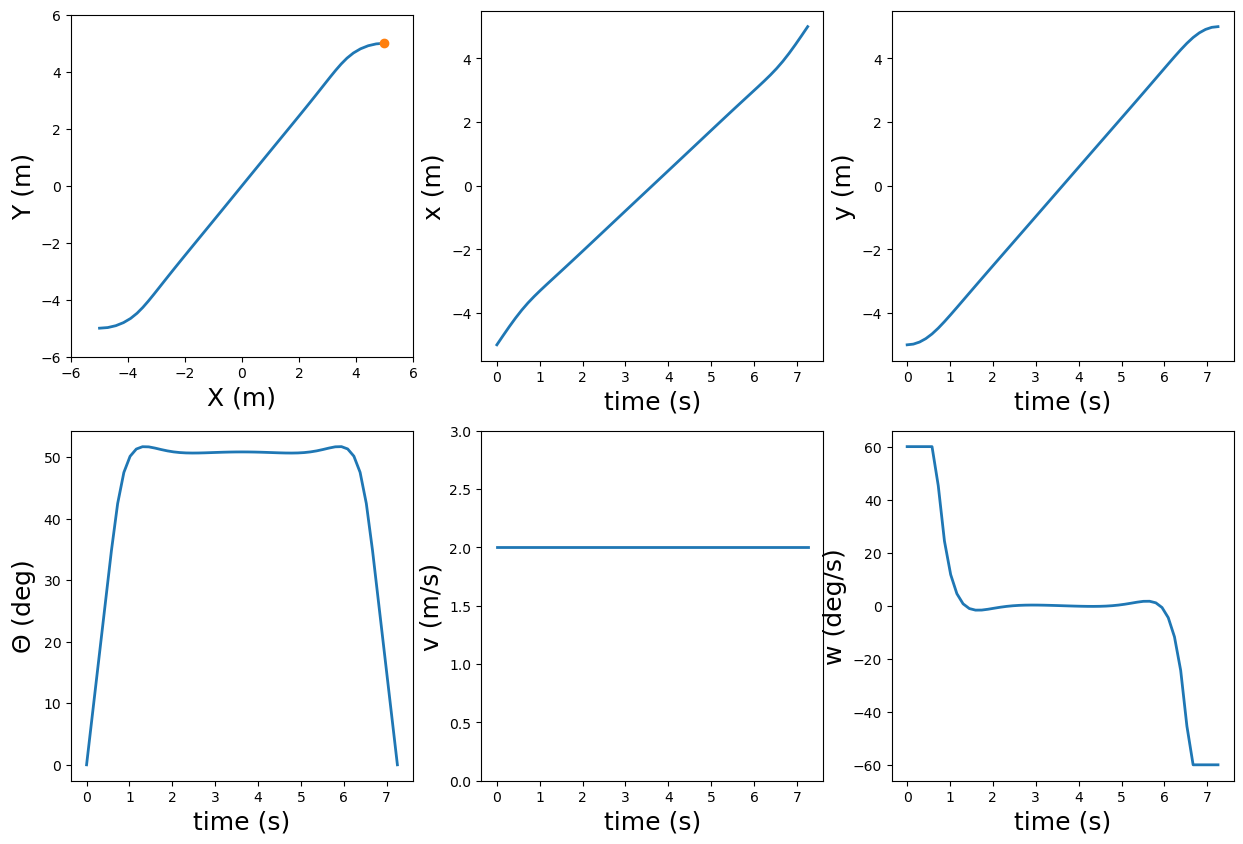

In [9]:
plt.figure(figsize=(15,10))
fS = 18
plt.subplot(231)
plt.plot(xnom[:,0], xnom[:,1],'-', linewidth=2.0)
plt.plot(xf[0],xf[1],"o",label='goal')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.subplot(232)
plt.plot(t_nom, xnom[:,0],'-', linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x (m)', fontsize = fS)
plt.subplot(233)
plt.plot(t_nom, xnom[:,1],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('y (m)', fontsize = fS)
plt.subplot(234)
plt.plot(t_nom, np.rad2deg(xnom[:,2]),'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$\Theta$ (deg)', fontsize = fS)
plt.subplot(235)
plt.plot(t_nom, unom[:,0],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('v (m/s)', fontsize = fS)
plt.ylim([0,3])
plt.subplot(236)
plt.plot(t_nom, np.rad2deg(unom[:,1]),'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w (deg/s)', fontsize = fS)
plt.show()

## Set MPC controller with static obstacle

### nominal trajectory is given as xbar, ubar

In [10]:
fun_unom = interp1d(t_nom,unom,axis=0)
def get_traj_teval(t_eval) :
    if len(t_eval) == 0 :
        return [],[]
    assert np.max(t_eval) <= t_nom[-1]
    def dfdt(t,x) :
        u = fun_unom(t)
        return np.squeeze(myModel.forward(x,u))

    sol = solve_ivp(dfdt,(t_nom[0],t_nom[-1]),xi,t_eval=t_eval,rtol=1e-12,atol=1e-12)
    return sol.y.T,fun_unom(t_eval)

def forward_dt(dt,xi,u) :
    def dfdt(t,x) :
        return np.squeeze(myModel.forward(x,u))
    sol = solve_ivp(dfdt,(0,dt),xi,rtol=1e-12,atol=1e-12)
    return sol
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])

In [11]:
tbar = np.array([i for i in range(N+1)]) / N * tfnom
tfsim = 8
horizon = 2
dt = 0.1
Nsim = int(tfsim / dt)
Nmpc =  int(horizon / dt) # N+1 is total discretization points for state
print("Nmpc: {:}".format(Nmpc))

xi_mpc = np.zeros(3)
xi_mpc[0] = -5.0
xi_mpc[1] = -4.0 
xi_mpc[2] = 0

Nmpc: 20


In [12]:
# cost and constraint / model is identical
MPC_model = UnicycleModel.unicycle2('Hello',ix,iu,'analytic')
MPC_Cost = UnicycleCost.UnicycleMPCCost('Hello',ix,iu,Nmpc)
MPC_Const = UnicycleConstraints.UnicycleMPCConstraints('Hello',ix,iu,num_obs=1)

# # define optimal control
MPC_controller = PTR_in_MPC('unicycle',Nmpc,horizon,max_iter,myModel,MPC_Cost,MPC_Const,myScaling,
          type_discretization="zoh",w_c=1,w_vc=1e3,w_tr=1e-1,
                            tol_vc=1e-6,tol_tr=1e-3,verbosity=False)

Is DPP?  True


In [13]:
# funnel initialization
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from funlopt import funlopt,funlopt_with_LQR_fixed_Q
from Lipschitz import Lipschitz
iw,iq,ip = MPC_model.iw,MPC_model.iq,MPC_model.ip
C,D,E,G = MPC_model.C,MPC_model.D,MPC_model.E,MPC_model.G
xfwd,ufwd = get_traj_teval(np.array([dt*i for i in range(Nmpc+1)]))

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2]) / 5
# Qini = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])

Qhat = np.tile(np.diag([0.2**2,0.2**2,np.deg2rad(10)**2]),(Nmpc+1,1,1))*0.1
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(xfwd[0:Nmpc,:],ufwd[0:Nmpc,:],dt,horizon) 
Khat = get_K_discrete(A,B,MPC_Cost.S,MPC_Cost.R,MPC_Cost.S,Nmpc,ix,iu)
Yhat = Khat@Qhat[:Nmpc]

funl_solver = funlopt_with_LQR_fixed_Q(ix,iu,iq,ip,iw,Nmpc,myScaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=0,
                      flag_nonlinearity=True)
funl_solver.cvx_initialize(2*Qini,Qini)

lip_estimator = Lipschitz(ix,iu,iq,ip,iw,Nmpc,num_sample=100,flag_uniform=True)

nonlinear funnel
Is DPP?  False


In [14]:
# moving obstacle
t_curr = 0
def fun_obstacle(t_eval) :
    t_eval = np.array(t_eval)
    N = len(t_eval)
    x = -0.5*t_eval + 2
    y = -10/8*t_eval + 5
    cobs = []
    Hobs = []
    H = get_H_obs(1,1) # fixed radius
    for i in range(N) :
        cobs.append([x[i],y[i]])
        Hobs.append(H)
    return cobs,Hobs

In [16]:
import time

t_curr = 0
x_curr = np.copy(xi_mpc)

t_save,x_save,u_save = [],[],[]
t_save.append(t_curr)
x_save.append(xi_mpc)

t_traj,x_traj,u_traj = [],[],[]
Q_traj,K_traj = [],[]
c_traj,H_traj = [],[]

time_traj,time_lips,time_funl = [],[],[]
list_cost_funl = []

for _ in range(Nsim) : # Nsim
# for _ in range(1) : # Nsim
    print("t curr: {:.2f}  ======================".format(t_curr))
    # estimating nominal trajectory within horizon
    t_horizon = np.array([t_curr + dt*i for i in range(Nmpc+1)])
    t_eval = t_horizon[t_horizon <= tfnom]
    t_end = t_horizon[t_horizon > tfnom]
    xfwd,ufwd = get_traj_teval(t_eval)
    for _ in t_end :
        if len(xfwd) == 0 :
            xfwd = xnom[-1]
            ufwd = unom[-1]
        else :
            xfwd = np.vstack((xfwd,xnom[-1]))
            ufwd = np.vstack((ufwd,unom[-1]))
    
    # obstacle forward model
    cmpc,Hmpc = fun_obstacle(t_horizon)
    
    # solve optimal control
    # initiall condition
    if t_curr == 0 :
        x0 = xfwd
        u0 = ufwd
        Q0 = Qhat
    else :
        x0 = np.copy(xmpc)
        x0[:Nmpc] = xmpc[1:]
        u0 = np.copy(umpc)
        u0[:Nmpc] = umpc[1:]
        
        Q0 = np.copy(Qmpc)
        Q0[:Nmpc] = Q0[1:]

    # solve MPC by OCP
    tic = time.time()
    xprop,uprop,xmpc,umpc,tfmpc,_,l_all,l_c,l_vc,l_tr,history_mpc = MPC_controller.run(x0,u0,x_curr,xfwd,ufwd,cmpc,Hmpc)
    time_traj.append(time.time() - tic)
    # discretization
    A,B,F,s,z,_ = MPC_model.diff_discrete_zoh_noise(xmpc,umpc,np.zeros((Nmpc,iw)),dt,horizon) 
    # compute K
    Kmpc = get_K_discrete(A,B,MPC_Cost.S,MPC_Cost.R,MPC_Cost.S,Nmpc,ix,iu)
    # estimate Lipschitz
    tic = time.time()
    lip_estimator.initialize(xmpc,umpc,xprop,Q0,Kmpc,A,B,C,D,E,F,G,MPC_model)
    gamma = lip_estimator.update_lipschitz_norm(MPC_model,dt)
    time_lips.append(time.time() - tic)
    # Funnel synthesis
    tic = time.time()
    Qmpc,svmpc,status,cost_state_funl,cost_input_funl = funl_solver.solve(gamma,Q0,Kmpc,A,B,C,D,E,F,G)
    time_funl.append(time.time() - tic)
    list_cost_funl.append([cost_state_funl,cost_input_funl])
    
    # apply input to the system (integration)
    sol = forward_dt(dt,x_curr,umpc[0])
    t_curr += dt
    x_curr = sol.y.T[-1]

    # save
    t_save.append(t_curr)
    x_save.append(x_curr)
    u_save.append(umpc[0])

    t_traj.append(t_horizon)
    x_traj.append(xmpc)
    u_traj.append(umpc)
    Q_traj.append(Qmpc)
    K_traj.append(Kmpc)
    c_traj.append(cmpc)
    H_traj.append(Hmpc)

x_save = np.array(x_save)
u_save = np.array(u_save)

t curr: 0.00  ======================
t curr: 0.10  ======================
t curr: 0.20  ======================
t curr: 0.30  ======================
t curr: 0.40  ======================
t curr: 0.50  ======================
t curr: 0.60  ======================
t curr: 0.70  ======================
t curr: 0.80  ======================
t curr: 0.90  ======================
t curr: 1.00  ======================
t curr: 1.10  ======================
t curr: 1.20  ======================
t curr: 1.30  ======================
t curr: 1.40  ======================
t curr: 1.50  ======================
t curr: 1.60  ======================
t curr: 1.70  ======================
t curr: 1.80  ======================
t curr: 1.90  ======================
t curr: 2.00  ======================
t curr: 2.10  ======================
t curr: 2.20  ======================
t curr: 2.30  ======================
t curr: 2.40  ======================
t curr: 2.50  ======================
t curr: 2.60  ======================
t

# summary

In [17]:
print("mean time for funnel {:}".format(np.mean(time_funl)))
print("mean time for traj {:}".format(np.mean(time_traj)))

print("cost for funnel {:}".format(np.mean(list_cost_funl)))
list_cost_funl[0]

mean time for funnel 0.36630998849868773
mean time for traj 0.03642159104347229
cost for funnel 22.110352871684025


[4.266007540845627, 30.050198029382447]

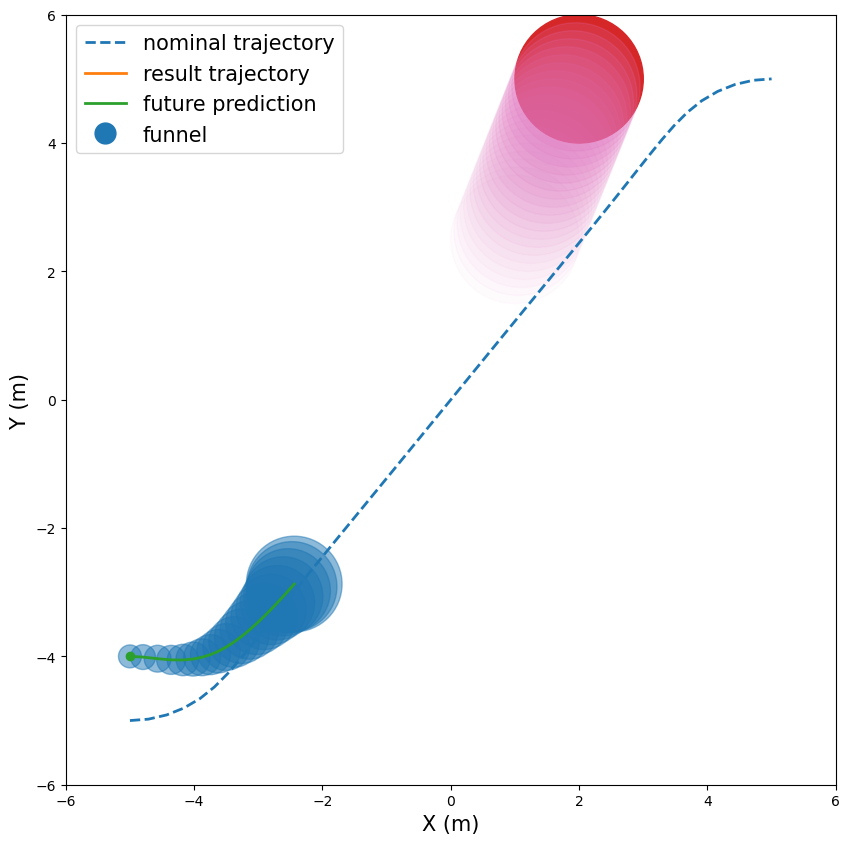

In [18]:
from matplotlib.patches import Ellipse
from utils.utils_plot import plot_funnel
idx = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fS = 15
plt.plot(xnom[:,0], xnom[:,1],'--', linewidth=2.0,label='nominal trajectory')
plt.plot(x_save[:idx+1,0], x_save[:idx+1,1],'-', linewidth=2.0,label='result trajectory')
if idx < Nsim :
    cmpc = c_traj[idx]
    Hmpc = H_traj[idx]
for idx_obstacle, (ce,H) in enumerate(zip(cmpc,Hmpc)) :
    rx = 1/H[0,0]
    ry = 1/H[1,1]
    if idx_obstacle == 0:
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=1.0,fill=True)
    else :
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:pink',alpha=0.2*np.exp(-idx_obstacle/10),fill=True)
    ax.add_patch(circle1)
if idx < Nsim :
    plt.plot(x_traj[idx][:,0], x_traj[idx][:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
    plt.plot(x_traj[idx][0,0], x_traj[idx][0,1],'o',color='tab:green', linewidth=2.0)
    plot_funnel(x_traj[idx],Q_traj[idx],ax)

plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.legend(fontsize=fS)


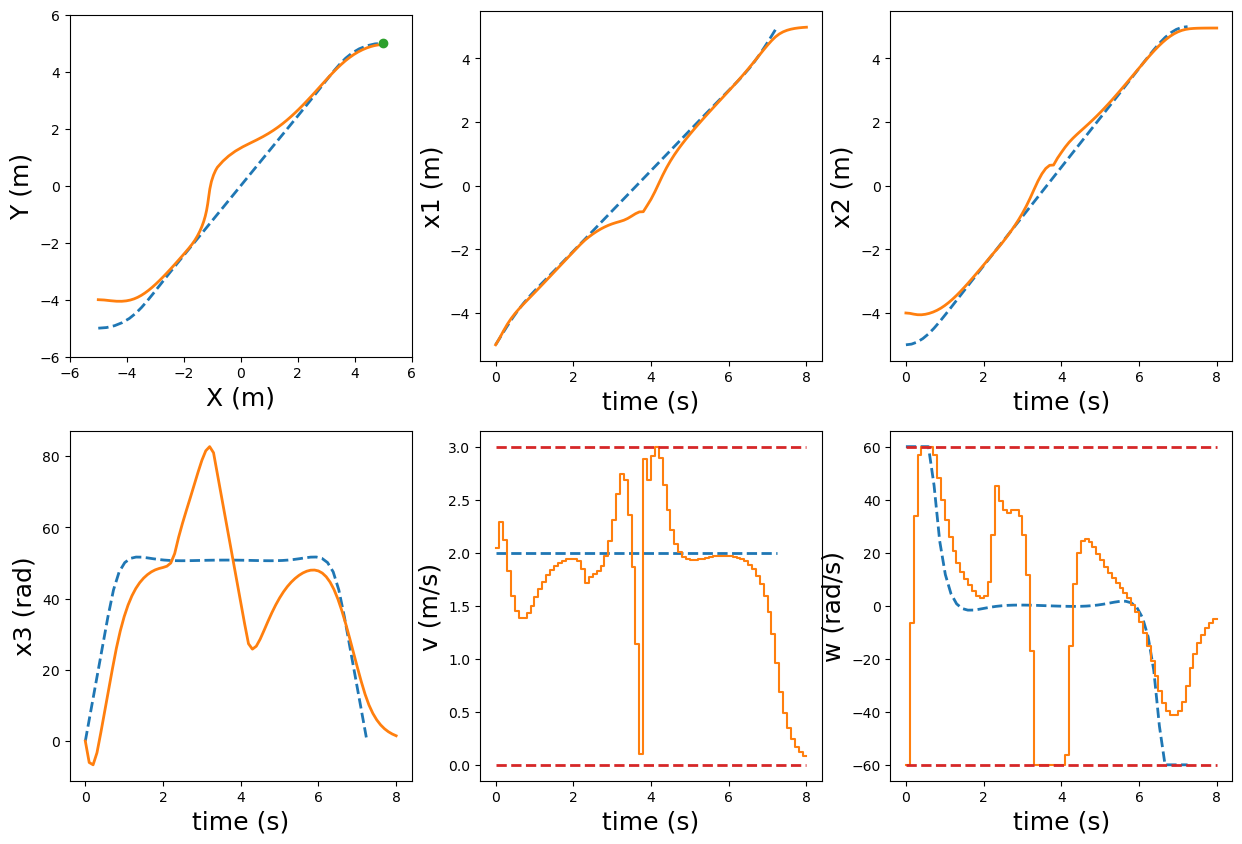

In [19]:
plt.figure(figsize=(15,10))
fS = 18
plt.subplot(231)
plt.plot(xnom[:,0], xnom[:,1],'--', linewidth=2.0)
plt.plot(x_save[:,0], x_save[:,1],'-', linewidth=2.0)
plt.plot(xf[0],xf[1],"o",label='goal')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.subplot(232)
plt.plot(t_nom, xnom[:,0],'--', linewidth=2.0)
plt.plot(t_save, x_save[:,0],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x1 (m)', fontsize = fS)
plt.subplot(233)
plt.plot(t_nom, xnom[:,1],'--',linewidth=2.0)
plt.plot(t_save, x_save[:,1],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x2 (m)', fontsize = fS)
plt.subplot(234)
plt.plot(t_nom, np.rad2deg(xnom[:,2]),'--',linewidth=2.0)
plt.plot(t_save, np.rad2deg(x_save[:,2]),'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x3 (rad)', fontsize = fS)
plt.subplot(235)
plt.plot(t_nom, unom[:,0],'--',linewidth=2.0)
plt.step(t_save,[*u_save[:,0],u_save[-1,0]],label='zoh',where='post')
plt.plot(t_save, np.array(t_save)*0+MPC_Const.vmax,'--',linewidth=2.0,color='tab:red')
plt.plot(t_save, np.array(t_save)*0+MPC_Const.vmin,'--',linewidth=2.0,color='tab:red')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('v (m/s)', fontsize = fS)
plt.subplot(236)
plt.plot(t_nom, np.rad2deg(unom[:,1]),'--',linewidth=2.0)
plt.step(t_save,np.rad2deg([*u_save[:,1],u_save[-1,1]]),label='zoh',where='post')
plt.plot(t_save, np.array(t_save)*0+np.rad2deg(MPC_Const.wmax),'--',linewidth=2.0,color='tab:red')
plt.plot(t_save, np.array(t_save)*0+np.rad2deg(MPC_Const.wmin),'--',linewidth=2.0,color='tab:red')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w (rad/s)', fontsize = fS)
plt.show()

## make a video

In [20]:
from matplotlib.patches import Rectangle,Ellipse
from utils.utils_plot import plot_funnel
import imageio.v2 as imageio
import os


In [21]:
filenames = []
t_curr = 0
for idx in range(Nsim+1) :
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    fS = 15
    plt.plot(xnom[:,0], xnom[:,1],'--', linewidth=2.0,label='nominal trajectory')
    plt.plot(x_save[:idx+1,0], x_save[:idx+1,1],'-', linewidth=2.0,label='result trajectory')
    if idx < Nsim :
        cmpc = c_traj[idx]
        Hmpc = H_traj[idx]
    for idx_obstacle, (ce,H) in enumerate(zip(cmpc,Hmpc)) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        if idx_obstacle == 0:
            circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=1.0,fill=True)
        else :
            circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:pink',alpha=0.2*np.exp(-idx_obstacle/10),fill=True)
        ax.add_patch(circle1)
    if idx < Nsim :
        plt.plot(x_traj[idx][:,0], x_traj[idx][:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
        plt.plot(x_traj[idx][0,0], x_traj[idx][0,1],'o',color='tab:green', linewidth=2.0)
        plot_funnel(x_traj[idx],Q_traj[idx],ax)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis([-6, 6, -6, 6])
    plt.xlabel('X (m)', fontsize = fS)
    plt.ylabel('Y (m)', fontsize = fS)
    plt.legend(fontsize=fS)

    filename = '../images/{:d}.png'.format(idx)
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    t_curr += dt

In [22]:
funnel_type = "LQR_K_fix_Q"
img_name = 'MPC_with_funnel_' + funnel_type
with imageio.get_writer('../images/'+img_name+'.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [23]:
img_name = 'video_MPC_with_funnel_' + funnel_type
with imageio.get_writer('../images/'+img_name+'.mov', fps=int(1/dt)) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [24]:
for filename in set(filenames):
    os.remove(filename)

In [ ]:
idx = 79
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fS = 15
plt.plot(xnom[:,0], xnom[:,1],'--', linewidth=2.0,label='nominal trajectory')
plt.plot(x_save[:idx+1,0], x_save[:idx+1,1],'-', linewidth=2.0,label='result trajectory')
if idx < Nsim :
    cmpc = c_traj[idx]
    Hmpc = H_traj[idx]
for idx_obstacle, (ce,H) in enumerate(zip(cmpc,Hmpc)) :
    rx = 1/H[0,0]
    ry = 1/H[1,1]
    if idx_obstacle == 0:
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=1.0,fill=True)
    else :
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:pink',alpha=0.2*np.exp(-idx_obstacle/10),fill=True)
    ax.add_patch(circle1)
if idx < Nsim :
    plt.plot(x_traj[idx][:,0], x_traj[idx][:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
    plt.plot(x_traj[idx][0,0], x_traj[idx][0,1],'o',color='tab:green', linewidth=2.0)
    plot_funnel(x_traj[idx],Q_traj[idx],ax)

plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.legend(fontsize=fS)
